<a href="https://colab.research.google.com/github/AAMuktadir/image-processing/blob/main/Milestone2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import

In [ ]:
# @title
import os
import pathlib

import matplotlib.pyplot as plt
import seaborn as sn

from PIL import Image

import numpy as np

from sklearn import datasets, preprocessing, linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from skimage.filters import unsharp_mask
from skimage import io
from skimage.color import rgb2lab

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical, plot_model

import pandas as pd

# CONFIGURATION

In [ ]:
# @title
SEED = 25
BATCH_SIZE = 32

# Load Dataset

In [ ]:
# @title
!gdown 1volrqRL3dWXliiQawsGgifJd1BkJiEiz
!unzip -q "Group_4.zip" -d ""

Downloading...
From: https://drive.google.com/uc?id=1volrqRL3dWXliiQawsGgifJd1BkJiEiz
To: /content/Group_4.zip
100% 4.93M/4.93M [00:00<00:00, 27.0MB/s]


In [ ]:
# @title
train_folder = 'Group_4/train'
test_folder = 'Group_4/test'
class_names = [file for file in os.listdir(train_folder) if not file.startswith('.')]

class_counts = {}

for class_name in class_names:
    class_path = os.path.join(train_folder, class_name)
    if os.path.isdir(class_path):
        class_count = len(os.listdir(class_path))
        class_counts[class_name] = class_count

In [ ]:
# @title
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_folder,
    label_mode='categorical',
    validation_split=0.2,
    subset="training",
    seed=SEED
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_folder,
    validation_split=0.2,
    subset="validation",
    label_mode='categorical',
    seed=SEED
)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_folder,
    validation_split=None,
    label_mode='categorical',
    seed=SEED
)

test_ds_without_batch = tf.keras.preprocessing.image_dataset_from_directory(
    test_folder,
    validation_split=None,
    label_mode='categorical',
    seed=SEED,
    batch_size=None
)

Found 2150 files belonging to 5 classes.
Using 1720 files for training.
Found 2150 files belonging to 5 classes.
Using 430 files for validation.
Found 250 files belonging to 5 classes.
Found 250 files belonging to 5 classes.


In [ ]:
# @title
def batchdataset_to_test(batchdataset):
    test_x = []
    test_y = []
    for batch in batchdataset:
        x, y = batch
        test_x.append(x.numpy())
        test_y.append(y.numpy())
    test_x = np.concatenate(test_x)
    test_y = np.concatenate(test_y)
    return test_x, test_y
test_x, test_y = batchdataset_to_test(test_ds)
test_X_np = np.array([image.numpy() for image, label in test_ds_without_batch])
test_y_np = np.array([label.numpy() for image, label in test_ds_without_batch])

# Normalize and Visualize Dataset

In [ ]:
# @title
def normalize_dataset(image,label):
    image = tf.cast(image/255. ,tf.float32)
    return image,label

train_ds = train_ds.map(normalize_dataset)
val_ds = val_ds.map(normalize_dataset)
test_ds = test_ds.map(normalize_dataset)

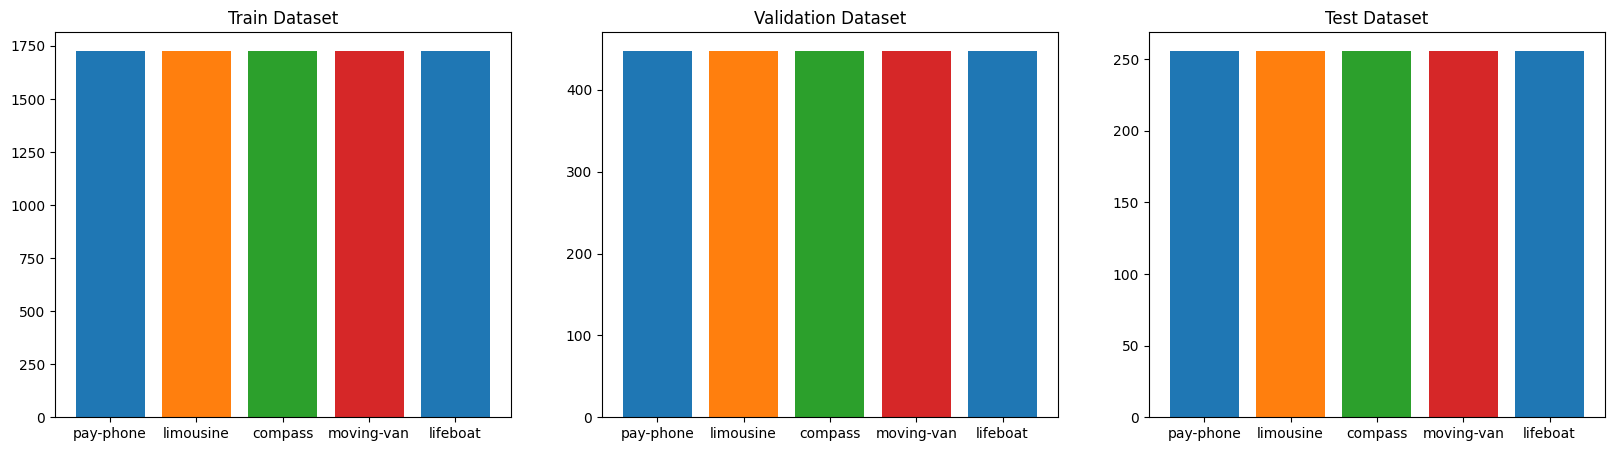

In [ ]:
# @title
# plot train_ds, val_ds, test_ds dataset size balance bar graph from dataset side by side
def plot_bargraph(train_ds, val_ds, test_ds):
    plt.figure(figsize=(20, 5))
    plt.subplot(1, 3, 1)
    plt.title('Train Dataset')
    color = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
    plt.bar(class_counts.keys(), train_ds.reduce(0, lambda x, _: x + 1).numpy()*BATCH_SIZE, color=color)
    plt.subplot(1, 3, 2)
    plt.title('Validation Dataset')
    plt.bar(class_counts.keys(), val_ds.reduce(0, lambda x, _: x + 1).numpy()*BATCH_SIZE, color=color)
    plt.subplot(1, 3, 3)
    plt.title('Test Dataset')
    plt.bar(class_counts.keys(), test_ds.reduce(0, lambda x, _: x + 1).numpy()*BATCH_SIZE, color=color)
    plt.show()

plot_bargraph(train_ds, val_ds, test_ds)

# Data Augmentation

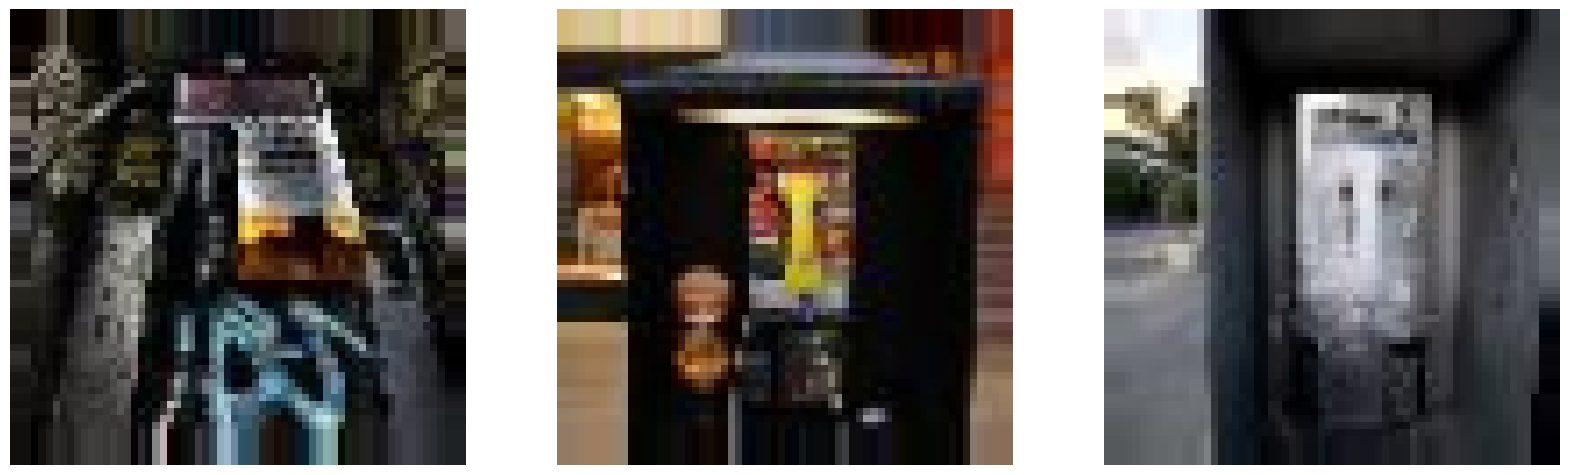

In [ ]:
# @title
#Cell added by Abdullah Al Muktadir
#Augmentaion: zoomimg in
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np

# Zooming image
datagen = ImageDataGenerator(zoom_range=[1.0,1.2])

train_folder = 'Group_4/train'
class_names = [file for file in os.listdir(train_folder) if not file.startswith('.')]
first_class_images = [os.path.join(train_folder, class_names[0], img) for img in os.listdir(os.path.join(train_folder, class_names[0]))]

# I have took first three images from the Train
imgs = [image.load_img(img_path) for img_path in first_class_images[:3]]

# this will display the augmented images
fig, ax = plt.subplots(1, 3, figsize=(20, 6))
for i, img in enumerate(imgs):
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    aug_iter = datagen.flow(img_array)
    aug_img = next(aug_iter)[0].astype('uint8')

    ax[i].imshow(aug_img)
    ax[i].axis('off')

plt.show()

# Helper Functions

In [ ]:
# @title
def genarate_report(model):
  y_pred = model.predict(test_ds)
  y_pred = np.round(y_pred)
  report = classification_report(test_y, y_pred, target_names=class_names)
  print(report)

In [ ]:
# @title
def genarate_confusion_matrix(model):
  y_pred = model.predict(test_ds)
  confusion = confusion_matrix(np.argmax(test_y, axis=1), np.argmax(y_pred, axis=1))
  ax = plt.axes()
  sn.heatmap(confusion, annot=True, annot_kws={"size": 12}, xticklabels=class_names, yticklabels=class_names, ax = ax)
  plt.xlabel('Predicted')
  plt.ylabel('Actual')
  ax.set_title('Confusion matrix')
  plt.show()

In [ ]:
# @title
def plot_test_validation_loss(history):
  plt.plot(history.history['loss'], label='Training Loss')
  plt.plot(history.history['val_loss'], label='Validation Loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()

In [ ]:
# @title
def calculate_metrics(confusion_matrix, class_names):
    num_classes = len(confusion_matrix)
    metrics = []
    for i in range(num_classes):
        TP = confusion_matrix[i, i]
        FP = np.sum(confusion_matrix[:, i]) - TP
        FN = np.sum(confusion_matrix[i, :]) - TP
        TN = np.sum(confusion_matrix) - (TP + FP + FN)

        ss = TP / (TP + FN)
        sp = TN / (TN + FP)
        PPV = TP / (TP + FP)
        NPV = TN / (TN + FN)

        metrics.append({
            'Class': class_names[i],
            'Sensitivity': ss,
            'Specificity': sp,
            'PPV': PPV,
            'NPV': NPV
        })

    return metrics

def get_performance_matrix(model):
  y_pred = model.predict(test_ds)
  confusion = confusion_matrix(np.argmax(test_y, axis=1), np.argmax(y_pred, axis=1))
  for metric in calculate_metrics(confusion, class_names):
      print(f"Class {metric['Class']}:")
      print(f"Sensitivity: {metric['Sensitivity']:.2f}")
      print(f"Specificity: {metric['Specificity']:.2f}")
      print(f"PPV: {metric['PPV']:.2f}")
      print(f"NPV: {metric['NPV']:.2f}\n")

In [ ]:
def plot_mislabelled_images(model, file_name):
    y_pred = model.predict(test_ds)
    index_test = np.argmax(test_y_np, axis=1)
    index_pred = np.argmax(y_pred, axis=1)

    image_plt = []

    for i in range(len(y_pred)):
        if len(image_plt) >= 25:
            break
        if index_pred[i] != index_test[i]:
            image_plt.append((test_X_np[i], class_names[index_test[i]]))

    plt.figure(figsize=(10, 10))
    for i in range(25):
        plt.subplot(5, 5, i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(image_plt[i][0]/255.0, cmap=plt.cm.binary)
        plt.xlabel(image_plt[i][1])
    plt.savefig(f"{file_name}")
    plt.show()


# Custom CNN Model

In [ ]:
# @title
model_custom_cnn = tf.keras.Sequential([
    tf.keras.layers.Conv2D(filters=8, kernel_size=(3, 3), activation='relu',
                            input_shape=(256, 256, 3)),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=2),
    tf.keras.layers.Conv2D(filters=16, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=2),
    tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(len(class_names), activation='softmax')
])

In [ ]:
# @title
model_custom_cnn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# @title
model_custom_cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 8)       224       
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 8)       0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 16)      1168      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 62, 62, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 32)        4640      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 30, 30, 32)        0

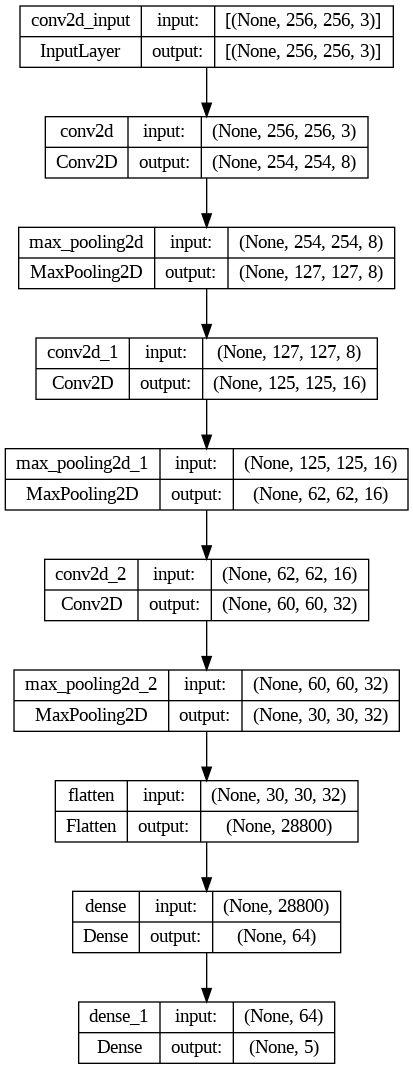

In [ ]:
plot_model(model_custom_cnn, show_shapes=True, show_layer_names=True)

In [ ]:
# @title
history = model_custom_cnn.fit(train_ds, epochs = 50, batch_size = 32)

Epoch 1/50
54/54 [==============================] - 26s 76ms/step - loss: 1.7511 - accuracy: 0.2459
Epoch 2/50
54/54 [==============================] - 4s 66ms/step - loss: 1.3949 - accuracy: 0.3994
Epoch 3/50
54/54 [==============================] - 4s 54ms/step - loss: 1.2102 - accuracy: 0.5116
Epoch 4/50
54/54 [==============================] - 4s 65ms/step - loss: 0.9832 - accuracy: 0.6256
Epoch 5/50
54/54 [==============================] - 4s 59ms/step - loss: 0.6950 - accuracy: 0.7436
Epoch 6/50
54/54 [==============================] - 2s 36ms/step - loss: 0.5191 - accuracy: 0.7965
Epoch 7/50
54/54 [==============================] - 2s 35ms/step - loss: 0.3308 - accuracy: 0.8860
Epoch 8/50
54/54 [==============================] - 2s 35ms/step - loss: 0.2189 - accuracy: 0.9326
Epoch 9/50
54/54 [==============================] - 2s 35ms/step - loss: 0.1381 - accuracy: 0.9651
Epoch 10/50
54/54 [==============================] - 3s 45ms/step - loss: 0.0770 - accuracy: 0.9820
Epoch 11

In [ ]:
# @title
preds = model_custom_cnn.evaluate(test_ds)
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

8/8 [==============================] - 1s 35ms/step - loss: 3.1612 - accuracy: 0.6520
Loss = 3.1611814498901367
Test Accuracy = 0.6520000100135803


# Results of Custom CNN

In [ ]:
# @title
genarate_report(model_custom_cnn)

8/8 [==============================] - 1s 22ms/step
              precision    recall  f1-score   support

   pay-phone       0.18      0.22      0.20        50
   limousine       0.25      0.16      0.20        50
     compass       0.19      0.16      0.17        50
  moving-van       0.15      0.18      0.16        50
    lifeboat       0.16      0.18      0.17        50

   micro avg       0.18      0.18      0.18       250
   macro avg       0.19      0.18      0.18       250
weighted avg       0.19      0.18      0.18       250
 samples avg       0.18      0.18      0.18       250



8/8 [==============================] - 0s 15ms/step


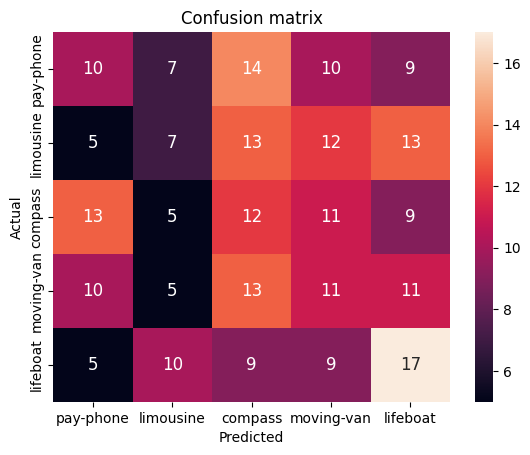

In [ ]:
# @title
genarate_confusion_matrix(model_custom_cnn)

In [ ]:
# @title
get_performance_matrix(model_custom_cnn)

8/8 [==============================] - 0s 19ms/step
Class pay-phone:
Sensitivity: 0.14
Specificity: 0.82
PPV: 0.16
NPV: 0.79

Class limousine:
Sensitivity: 0.10
Specificity: 0.85
PPV: 0.15
NPV: 0.79

Class compass:
Sensitivity: 0.12
Specificity: 0.72
PPV: 0.10
NPV: 0.77

Class moving-van:
Sensitivity: 0.22
Specificity: 0.79
PPV: 0.21
NPV: 0.80

Class lifeboat:
Sensitivity: 0.24
Specificity: 0.77
PPV: 0.20
NPV: 0.80



8/8 [==============================] - 0s 19ms/step


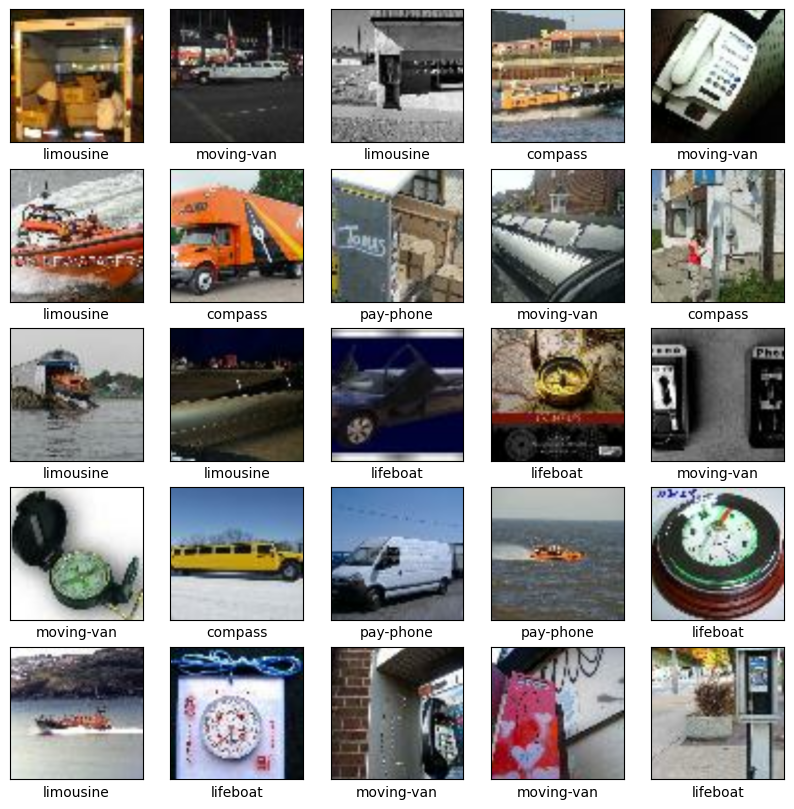

In [ ]:
plot_mislabelled_images(model_custom_cnn, 'CNN_mislabelled_images.png')

# ResNet50

In [ ]:
# @title
from keras.models import Model
from keras.initializers import glorot_uniform
from keras.layers import Input, Conv2D, MaxPooling2D, BatchNormalization, Activation, ReLU, Add, Flatten, Dense, GlobalAveragePooling2D, Layer, AveragePooling2D, ZeroPadding2D

In [ ]:
# @title
def identity_block(X, f, filters, stage, block):
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    F1, F2, F3 = filters
    X_shortcut = X
    X = Conv2D(filters = F1, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2a')(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)
    X = Conv2D(filters = F2, kernel_size = (f, f), strides = (1,1), padding = 'same', name = conv_name_base + '2b')(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)
    X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2c')(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)

    return X

In [ ]:
# @title
def convolutional_block(X, f, filters, stage, block, s = 2):
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    F1, F2, F3 = filters
    X_shortcut = X
    X = Conv2D(F1, (1, 1), strides = (s,s), name = conv_name_base + '2a')(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)
    X = Conv2D(filters = F2, kernel_size = (f, f), strides = (1,1), padding = 'same', name = conv_name_base + '2b')(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)
    X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2c')(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)
    X_shortcut = Conv2D(filters = F3, kernel_size = (1, 1), strides = (s,s), padding = 'valid', name = conv_name_base + '1')(X_shortcut)
    X_shortcut = BatchNormalization(axis = 3, name = bn_name_base + '1')(X_shortcut)
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)

    return X

In [ ]:
# @title
def ResNet50(input_shape=(64, 64, 3), classes=3):
    X_input = Input(input_shape)
    X = ZeroPadding2D((3, 3))(X_input)

    # Stage 1
    X = Conv2D(64, (7, 7), strides=(2, 2), name='conv1')(X)
    X = BatchNormalization(axis=3, name='bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    # Stage 2
    X = convolutional_block(X, f=3, filters=[64, 64, 256], stage=2, block='a', s=1)
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='b')
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='c')

    # Stage 3
    X = convolutional_block(X, f = 3, filters = [128, 128, 512], stage = 3, block='a', s = 2)
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='b')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='c')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='d')

    # Stage 4
    X = convolutional_block(X, f = 3, filters = [256, 256, 1024], stage = 4, block='a', s = 2)
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='b')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='c')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='d')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='e')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='f')

    # Stage 5
    X = convolutional_block(X, f = 3, filters = [512, 512, 2048], stage = 5, block='a', s = 2)
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='b')
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='c')

    # AVGPOOL
    X = AveragePooling2D((2,2), name="avg_pool")(X)

    # output layer
    X = Flatten()(X)
    X = Dense(classes, activation='softmax', name='fc' + str(classes), kernel_initializer = glorot_uniform(seed=0))(X)

    # Create model
    model = Model(inputs = X_input, outputs = X, name='ResNet50')

    return model

In [ ]:
# @title
model_resnet50 = ResNet50(input_shape = (256, 256, 3), classes = len(class_names))

In [ ]:
# @title
model_resnet50.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# @title
model_resnet50.summary()

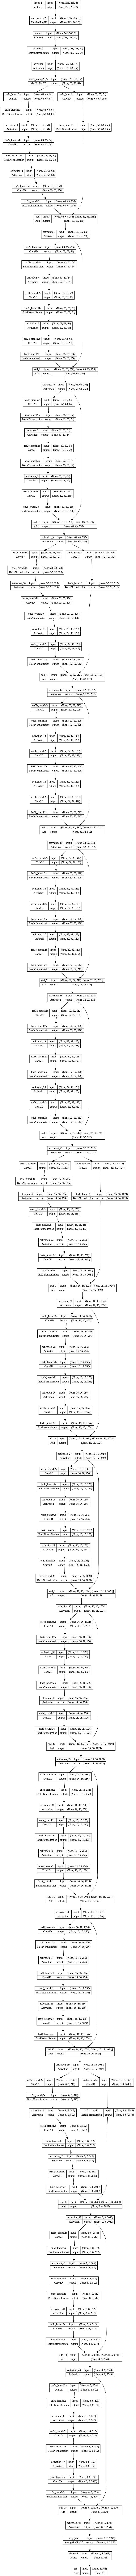

In [ ]:
plot_model(model_resnet50, show_shapes=True, show_layer_names=True)

In [ ]:
# @title
model_resnet50.fit(train_ds, epochs = 50, batch_size = 1)

Epoch 1/50
54/54 [==============================] - 63s 452ms/step - loss: 8.2357 - accuracy: 0.2517
Epoch 2/50
54/54 [==============================] - 21s 383ms/step - loss: 4.1940 - accuracy: 0.3203
Epoch 3/50
54/54 [==============================] - 21s 390ms/step - loss: 2.7246 - accuracy: 0.3965
Epoch 4/50
54/54 [==============================] - 21s 384ms/step - loss: 1.8719 - accuracy: 0.4767
Epoch 5/50
54/54 [==============================] - 21s 383ms/step - loss: 1.5693 - accuracy: 0.5360
Epoch 6/50
54/54 [==============================] - 21s 383ms/step - loss: 1.1613 - accuracy: 0.6110
Epoch 7/50
54/54 [==============================] - 21s 386ms/step - loss: 0.9368 - accuracy: 0.6680
Epoch 8/50
54/54 [==============================] - 21s 387ms/step - loss: 0.8537 - accuracy: 0.6919
Epoch 9/50
54/54 [==============================] - 21s 386ms/step - loss: 0.7340 - accuracy: 0.7448
Epoch 10/50
54/54 [==============================] - 21s 386ms/step - loss: 0.6849 - accura

In [ ]:
# @title
preds = model_resnet50.evaluate(test_ds)
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

8/8 [==============================] - 3s 283ms/step - loss: 1.6774 - accuracy: 0.7120
Loss = 1.6774444580078125
Test Accuracy = 0.7120000123977661


# ResNet Results

In [ ]:
# @title
genarate_report(model_resnet50)

8/8 [==============================] - 2s 114ms/step
              precision    recall  f1-score   support

   pay-phone       0.23      0.20      0.22        50
   limousine       0.21      0.20      0.20        50
     compass       0.20      0.24      0.22        50
  moving-van       0.24      0.22      0.23        50
    lifeboat       0.29      0.30      0.29        50

   micro avg       0.23      0.23      0.23       250
   macro avg       0.23      0.23      0.23       250
weighted avg       0.23      0.23      0.23       250
 samples avg       0.23      0.23      0.23       250



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


8/8 [==============================] - 1s 111ms/step


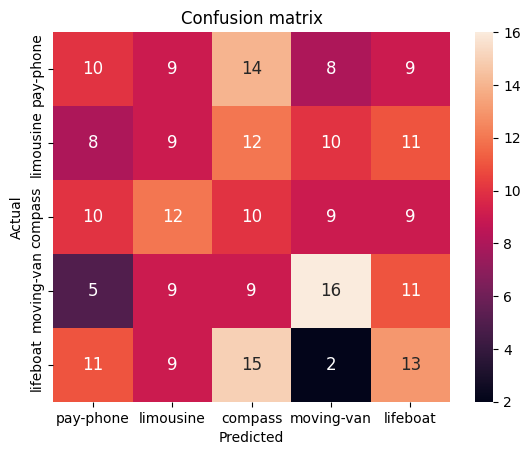

In [ ]:
# @title
genarate_confusion_matrix(model_resnet50)

In [ ]:
# @title
get_performance_matrix(model_resnet50)

8/8 [==============================] - 1s 110ms/step
Class pay-phone:
Sensitivity: 0.20
Specificity: 0.83
PPV: 0.23
NPV: 0.81

Class limousine:
Sensitivity: 0.18
Specificity: 0.81
PPV: 0.19
NPV: 0.80

Class compass:
Sensitivity: 0.22
Specificity: 0.76
PPV: 0.18
NPV: 0.79

Class moving-van:
Sensitivity: 0.18
Specificity: 0.82
PPV: 0.20
NPV: 0.80

Class lifeboat:
Sensitivity: 0.24
Specificity: 0.80
PPV: 0.23
NPV: 0.81



8/8 [==============================] - 1s 126ms/step


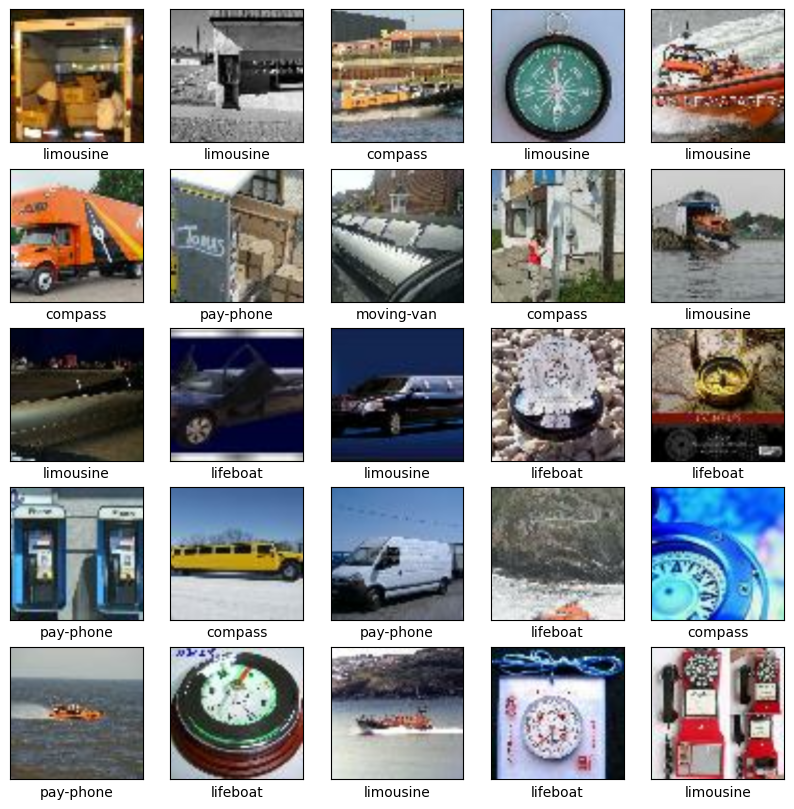

In [ ]:
plot_mislabelled_images(model_resnet50, 'ResNet_mislabelled_images.png')

# Inception

In [ ]:
# @title
def inception_module(x, f1, f2, f3):
	conv1 =  keras.layers.Conv2D(f1, (1,1), padding='same', activation='relu')(x)
	conv3 = keras.layers.Conv2D(f2, (3,3), padding='same', activation='relu')(x)
	conv5 = keras.layers.Conv2D(f3, (5,5), padding='same', activation='relu')(x)
	pool = keras.layers.MaxPooling2D((3,3), strides=(1,1), padding='same')(x)
	out = keras.layers.merge.concatenate([conv1, conv3, conv5, pool])
	return out

In [ ]:
# @title
img_input = keras.Input(shape=(64, 64, 3))
classes=len(class_names)
channel_axis=3

In [ ]:
# @title
def conv2d_bn(x,filters,num_row,num_col,padding='same',strides=(1, 1)):
    x = keras.layers.Conv2D(filters, (num_row, num_col),strides=strides,padding=padding)(x)
    x = keras.layers.BatchNormalization(axis=3, scale=False)(x)
    x = keras.layers.Activation('relu')(x)
    return x

In [ ]:
# @title
def inc_block_a(x):
    branch1x1 = conv2d_bn(x, 64, 1, 1)  # 64 filters of 1*1

    branch5x5 = conv2d_bn(x, 48, 1, 1)  #48 filters of 1*1
    branch5x5 = conv2d_bn(branch5x5, 64, 5, 5)

    branch3x3dbl = conv2d_bn(x, 64, 1, 1)
    branch3x3dbl = conv2d_bn(branch3x3dbl, 96, 3, 3)
    branch3x3dbl = conv2d_bn(branch3x3dbl, 96, 3, 3)

    branch_pool = keras.layers.AveragePooling2D((3, 3), strides=(1, 1), padding='same')(x)
    branch_pool = conv2d_bn(branch_pool, 32, 1, 1)
    x = keras.layers.concatenate([branch1x1, branch5x5, branch3x3dbl, branch_pool], axis=channel_axis)
    return x

In [ ]:
# @title
def reduction_block_a(x):
    branch3x3 = conv2d_bn(x, 384, 3, 3, strides=(2, 2), padding='valid')

    branch3x3dbl = conv2d_bn(x, 64, 1, 1)
    branch3x3dbl = conv2d_bn(branch3x3dbl, 96, 3, 3)
    branch3x3dbl = conv2d_bn(branch3x3dbl, 96, 3, 3, strides=(2, 2), padding='valid')

    branch_pool = keras.layers.MaxPooling2D((3, 3), strides=(2, 2))(x)
    x = keras.layers.concatenate([branch3x3, branch3x3dbl, branch_pool],axis=channel_axis)
    return x

In [ ]:
# @title
def inc_block_b(x):
    branch1x1 = conv2d_bn(x, 192, 1, 1)

    branch7x7 = conv2d_bn(x, 128, 1, 1)
    branch7x7 = conv2d_bn(branch7x7, 128, 1, 7)
    branch7x7 = conv2d_bn(branch7x7, 192, 7, 1)

    branch7x7dbl = conv2d_bn(x, 128, 1, 1)
    branch7x7dbl = conv2d_bn(branch7x7dbl, 128, 7, 1)
    branch7x7dbl = conv2d_bn(branch7x7dbl, 128, 1, 7)
    branch7x7dbl = conv2d_bn(branch7x7dbl, 128, 7, 1)
    branch7x7dbl = conv2d_bn(branch7x7dbl, 192, 1, 7)

    branch_pool = keras.layers.AveragePooling2D((3, 3), strides=(1, 1),padding='same')(x)
    branch_pool = conv2d_bn(branch_pool, 192, 1, 1)
    x = keras.layers.concatenate([branch1x1, branch7x7, branch7x7dbl, branch_pool], axis=channel_axis)
    return x

In [ ]:
# @title
def reduction_block_b(x):
    branch3x3 = conv2d_bn(x, 192, 1, 1)
    branch3x3 = conv2d_bn(branch3x3, 320, 3, 3,strides=(2, 2), padding='valid')

    branch7x7x3 = conv2d_bn(x, 192, 1, 1)
    branch7x7x3 = conv2d_bn(branch7x7x3, 192, 1, 7)
    branch7x7x3 = conv2d_bn(branch7x7x3, 192, 7, 1)
    branch7x7x3 = conv2d_bn( branch7x7x3, 192, 3, 3, strides=(2, 2), padding='valid')

    branch_pool = keras.layers.MaxPooling2D((3, 3), strides=(2, 2))(x)
    x = keras.layers.concatenate([branch3x3, branch7x7x3, branch_pool], axis=channel_axis)
    return x

In [ ]:
# @title
def inc_block_c(x):
        branch1x1 = conv2d_bn(x, 320, 1, 1)

        branch3x3 = conv2d_bn(x, 384, 1, 1)
        branch3x3_1 = conv2d_bn(branch3x3, 384, 1, 3)
        branch3x3_2 = conv2d_bn(branch3x3, 384, 3, 1)
        branch3x3 = keras.layers.concatenate([branch3x3_1, branch3x3_2],axis=channel_axis)

        branch3x3dbl = conv2d_bn(x, 448, 1, 1)
        branch3x3dbl = conv2d_bn(branch3x3dbl, 384, 3, 3)
        branch3x3dbl_1 = conv2d_bn(branch3x3dbl, 384, 1, 3)
        branch3x3dbl_2 = conv2d_bn(branch3x3dbl, 384, 3, 1)
        branch3x3dbl = keras.layers.concatenate([branch3x3dbl_1, branch3x3dbl_2], axis=channel_axis)

        branch_pool = keras.layers.AveragePooling2D((3, 3), strides=(1, 1), padding='same')(x)
        branch_pool = conv2d_bn(branch_pool, 192, 1, 1)
        x = keras.layers.concatenate( [branch1x1, branch3x3, branch3x3dbl, branch_pool],axis=channel_axis)
        return x

In [ ]:
# @title
img_input = keras.Input(shape=(256, 256, 3))

In [ ]:
# @title
x = conv2d_bn(img_input, 32, 3, 3, strides=(2, 2), padding='valid')
x = conv2d_bn(x, 32, 3, 3, padding='valid')
x = conv2d_bn(x, 64, 3, 3) # 147 x 147 x 64

x = keras.layers.MaxPooling2D((3, 3), strides=(2, 2))(x)
x = conv2d_bn(x, 80, 1, 1, padding='valid')
x = conv2d_bn(x, 192, 3, 3, padding='valid')
x = keras.layers.MaxPooling2D((3, 3), strides=(2, 2))(x)


x=inc_block_a(x)
x=inc_block_a(x)
x=inc_block_a(x)

x=reduction_block_a(x)

x=inc_block_b(x)
x=inc_block_b(x)
x=inc_block_b(x)
x=inc_block_b(x)

x=reduction_block_b(x)

x=inc_block_c(x)
x=inc_block_c(x)

x = keras.layers.GlobalAveragePooling2D(name='avg_pool')(x)

x = keras.layers.Dense(classes, activation='softmax', name='predictions')(x)

inputs = img_input
model_inception =  keras.Model(inputs, x, name='inception_v3')

In [ ]:
# @title
model_inception.summary()

In [ ]:
plot_model(model_inception, show_shapes=True, show_layer_names=True)

In [ ]:
# @title
model_inception.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# @title
model_inception.fit(train_ds, epochs = 50, batch_size = 1)

Epoch 1/50
54/54 [==============================] - 75s 386ms/step - loss: 1.5641 - accuracy: 0.4221
Epoch 2/50
54/54 [==============================] - 16s 297ms/step - loss: 1.0630 - accuracy: 0.5959
Epoch 3/50
54/54 [==============================] - 17s 305ms/step - loss: 0.9188 - accuracy: 0.6680
Epoch 4/50
54/54 [==============================] - 17s 304ms/step - loss: 0.8372 - accuracy: 0.7017
Epoch 5/50
54/54 [==============================] - 16s 297ms/step - loss: 0.7036 - accuracy: 0.7477
Epoch 6/50
54/54 [==============================] - 16s 296ms/step - loss: 0.6909 - accuracy: 0.7413
Epoch 7/50
54/54 [==============================] - 16s 300ms/step - loss: 0.5861 - accuracy: 0.7901
Epoch 8/50
54/54 [==============================] - 17s 301ms/step - loss: 0.5633 - accuracy: 0.7971
Epoch 9/50
54/54 [==============================] - 16s 300ms/step - loss: 0.5214 - accuracy: 0.8157
Epoch 10/50
54/54 [==============================] - 16s 298ms/step - loss: 0.4740 - accura

In [ ]:
# @title
preds = model_inception.evaluate(test_ds)
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

8/8 [==============================] - 1s 99ms/step - loss: 1.1532 - accuracy: 0.7720
Loss = 1.153236985206604
Test Accuracy = 0.7720000147819519


#Inception Results

In [ ]:
genarate_report(model_inception)

8/8 [==============================] - 4s 103ms/step
              precision    recall  f1-score   support

   pay-phone       0.23      0.20      0.22        50
   limousine       0.17      0.14      0.15        50
     compass       0.19      0.16      0.17        50
  moving-van       0.22      0.22      0.22        50
    lifeboat       0.20      0.26      0.23        50

   micro avg       0.20      0.20      0.20       250
   macro avg       0.20      0.20      0.20       250
weighted avg       0.20      0.20      0.20       250
 samples avg       0.20      0.20      0.20       250



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


8/8 [==============================] - 1s 98ms/step


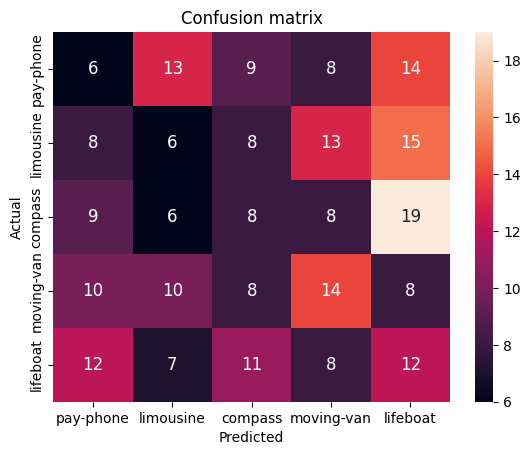

In [ ]:
genarate_confusion_matrix(model_inception)

In [ ]:
get_performance_matrix(model_inception)

8/8 [==============================] - 1s 92ms/step
Class pay-phone:
Sensitivity: 0.12
Specificity: 0.81
PPV: 0.13
NPV: 0.79

Class limousine:
Sensitivity: 0.10
Specificity: 0.81
PPV: 0.12
NPV: 0.78

Class compass:
Sensitivity: 0.18
Specificity: 0.82
PPV: 0.20
NPV: 0.80

Class moving-van:
Sensitivity: 0.24
Specificity: 0.81
PPV: 0.24
NPV: 0.81

Class lifeboat:
Sensitivity: 0.26
Specificity: 0.72
PPV: 0.19
NPV: 0.80



8/8 [==============================] - 1s 105ms/step


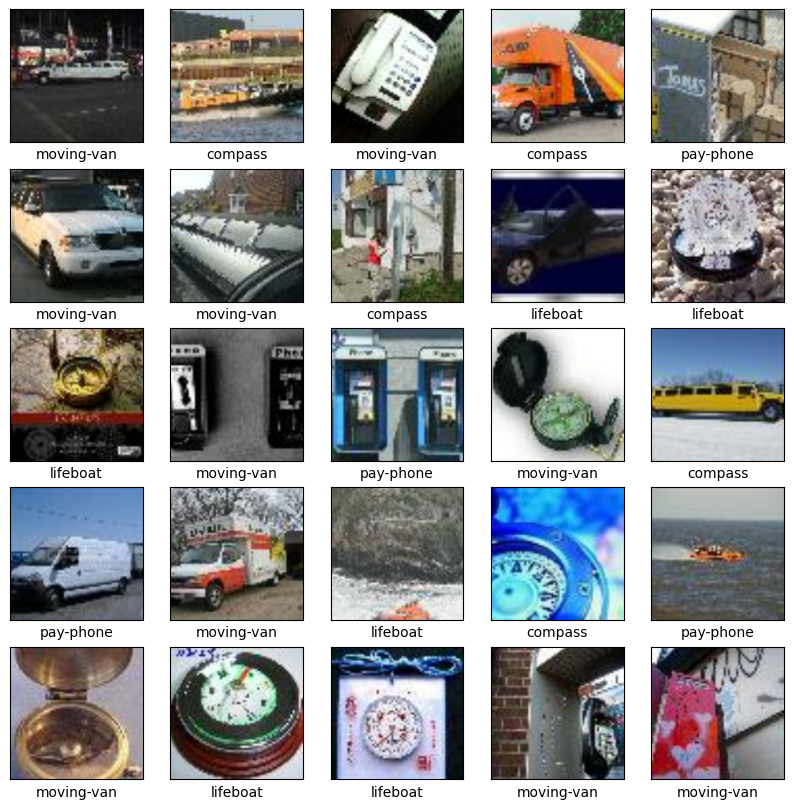

In [ ]:
plot_mislabelled_images(model_inception, 'Inception_mislabelled_images.png')